In [1]:
import pandas as pd
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.5)

In [2]:
# read T cell epitopes from file
tcell_dframe = pd.read_csv("tcell_full_v3.csv", low_memory=False, header=1)

# select eiptope information
selected_cols = ["Description", "Qualitative Measure", "Allele Name"]
epitopes = tcell_dframe.loc[tcell_dframe["Object Type"]=="Linear peptide", selected_cols]
epitopes.is_copy = False

# data overview
epitopes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270253 entries, 0 to 275073
Data columns (total 3 columns):
Description            270253 non-null object
Qualitative Measure    270253 non-null object
Allele Name            209260 non-null object
dtypes: object(3)
memory usage: 8.2+ MB


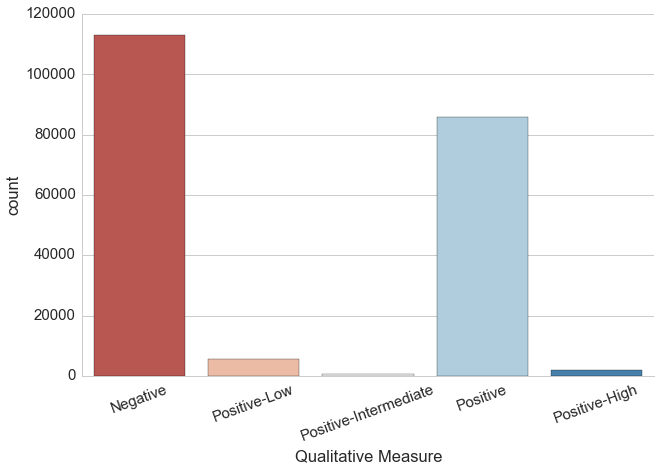

In [3]:
# clear up data
epitopes.dropna(inplace=True)

# keep peptide sequence only
epitopes["Description"] = epitopes["Description"].str.split().str.get(0)

# add a column for peptide length
epitopes["Length"] = epitopes["Description"].str.len()

# focus on peptides with 8-30 amino acids
epitopes = epitopes[(epitopes["Length"]>=8) & (epitopes["Length"]<=30)]

# visualzie the responsiveness of all the peptides
sns.factorplot("Qualitative Measure", data=epitopes, kind="count",
               order=["Negative", "Positive-Low", "Positive-Intermediate", "Positive", "Positive-High"],
               size=6, aspect=1.5, palette="RdBu").set_xticklabels(rotation=20)

####Interestingly, about half of the peptides in the database are negative

In [4]:
# now eleminate negative and duplicate peptides
epitopes = epitopes[epitopes["Qualitative Measure"] != "Negative"]
epitopes.is_copy = False
epitopes.drop_duplicates("Description", inplace=True)

# we are done with the Qualitative Measure column
epitopes.drop("Qualitative Measure", axis=1, inplace=True)
epitopes.reset_index(drop=True, inplace=True)

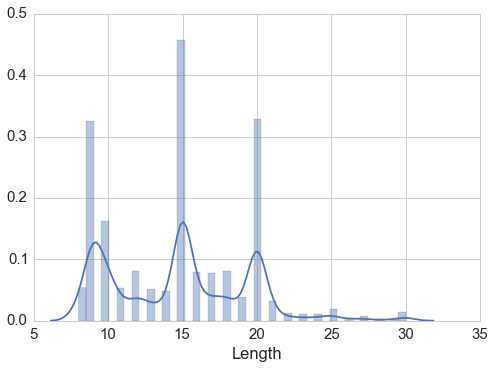

In [5]:
# plot the distribution of peptide length
sns.distplot(epitopes["Length"])

####We can see that peptides with 9, 15, or 20 amino acids are most abundant.

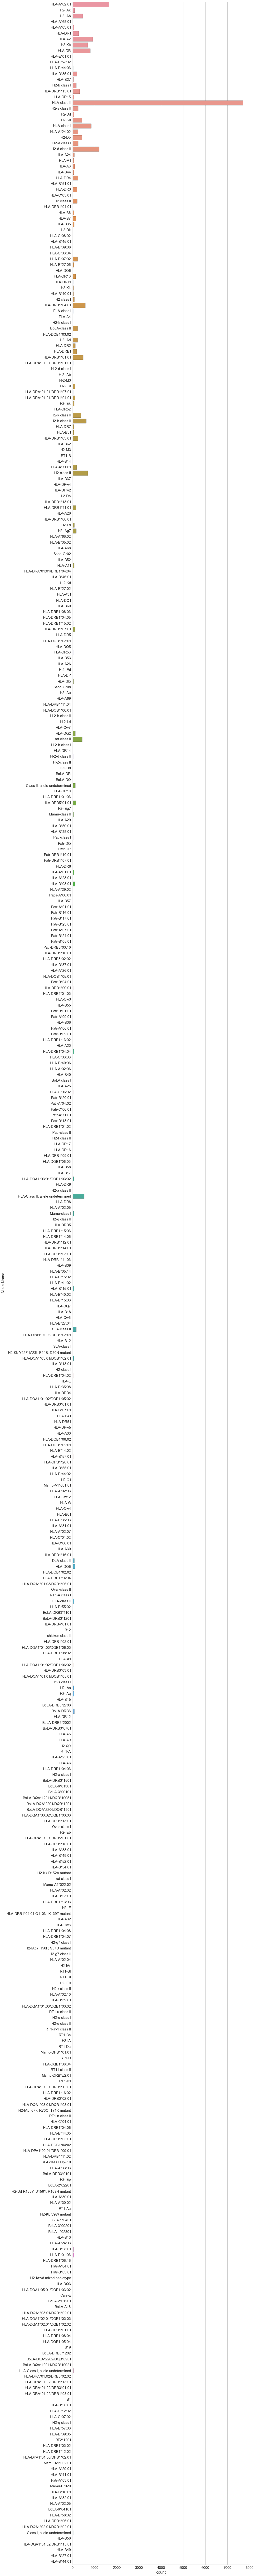

In [6]:
# now let's take a look at all the alleles
sns.factorplot(y="Allele Name", data=epitopes, kind="count", size=150, aspect=0.1)

####The graph shows that some MHC alleles bind to a lot of peptides, while some don't. Next, we will choose features and build a model to predict which MHC allele a peptide will bind to.

In [7]:
# since many of the MHC alleles have very few samples,
# we will only keep alleles that have more than 500 peptides to get meaningful predictions
allele_counts = epitopes["Allele Name"].value_counts()
alleles = allele_counts[allele_counts > 500].index.tolist()

epitopes = epitopes.loc[epitopes["Allele Name"].isin(alleles)]
epitopes.reset_index(drop=True, inplace=True)
epitopes = epitopes.ix[:, ["Allele Name", "Description", "Length", ]]

In [8]:
# a quick look at the dataset
epitopes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16231 entries, 0 to 16230
Data columns (total 3 columns):
Allele Name    16231 non-null object
Description    16231 non-null object
Length         16231 non-null int64
dtypes: int64(1), object(2)
memory usage: 507.2+ KB


In [9]:
epitopes.head()

,Allele Name,Description,Length
0,HLA-A*02:01,KLEDLERDL,9
1,HLA-A*02:01,DLMGYIPLV,9
2,HLA-A2,LITGRLQSL,9
3,H2-Kb,TRVAFAGL,8
4,H2-Kb,AIVNYANL,8


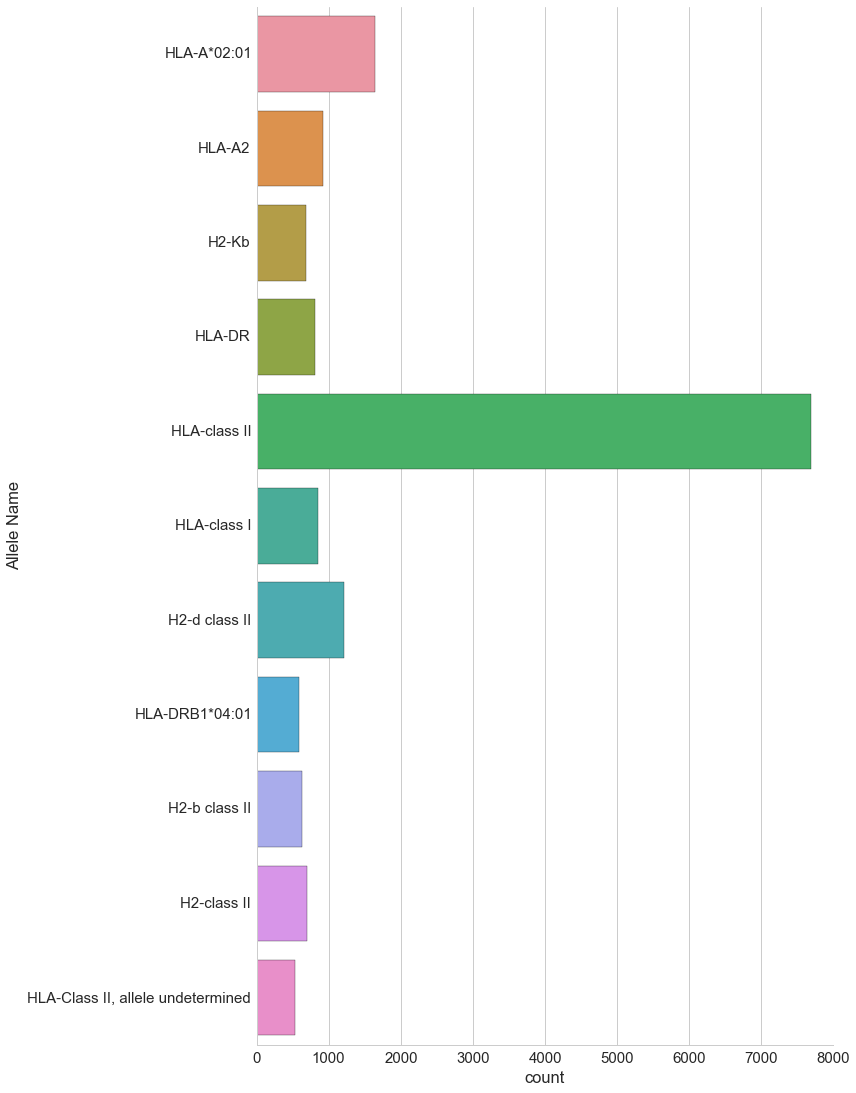

In [10]:
# the alleles we are going to predict and their peptides
sns.factorplot(y="Allele Name", data=epitopes, kind="count", size=15, aspect=0.8)

####We can see most peptides in our dataset bind to HLA-class II, which can biase our predictions.

In [11]:
# use integers to represent alleles
alleles_dict = {}
for i in range(len(alleles)):
    alleles_dict[alleles[i]] = i

In [12]:
# create a table for alleles orders as reference
allele_names = DataFrame(alleles_dict.items(), columns=["Allele", "Order"])
allele_names.sort("Order", inplace=True)
allele_names.set_index("Order", inplace=True)
allele_names

,Allele
Order,
0,HLA-class II
1,HLA-A*02:01
2,H2-d class II
3,HLA-A2
4,HLA-class I
5,HLA-DR
6,H2-class II
7,H2-Kb
8,H2-b class II


In [13]:
# extract features using the amino acid sequence
def to_ascii(letter):
    if pd.isnull(letter):
        return 0
    else:
        return ord(letter)

for i in range(30):
    col = "p" + str(i)
    epitopes[col] = epitopes["Description"].str.get(i)
    
    # use ascii number to represent each amino acid
    epitopes[col] = epitopes[col].map(to_ascii)
    epitopes[col] = epitopes[col].astype(float)

# convert alleles to numbers
epitopes["Allele Name"] = epitopes["Allele Name"].map(alleles_dict)
epitopes["Allele Name"] = epitopes["Allele Name"].astype(float)

# drop Description and Length columns
epitopes.drop(["Description", "Length"], axis=1, inplace=True)

epitopes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16231 entries, 0 to 16230
Data columns (total 31 columns):
Allele Name    16231 non-null float64
p0             16231 non-null float64
p1             16231 non-null float64
p2             16231 non-null float64
p3             16231 non-null float64
p4             16231 non-null float64
p5             16231 non-null float64
p6             16231 non-null float64
p7             16231 non-null float64
p8             16231 non-null float64
p9             16231 non-null float64
p10            16231 non-null float64
p11            16231 non-null float64
p12            16231 non-null float64
p13            16231 non-null float64
p14            16231 non-null float64
p15            16231 non-null float64
p16            16231 non-null float64
p17            16231 non-null float64
p18            16231 non-null float64
p19            16231 non-null float64
p20            16231 non-null float64
p21            16231 non-null float64
p22            16

In [14]:
# convert dataframe to numpy array before using machine learning
epitopes_array = epitopes.values
X = epitopes_array[0::, 1::]
y = epitopes_array[0::, 0]

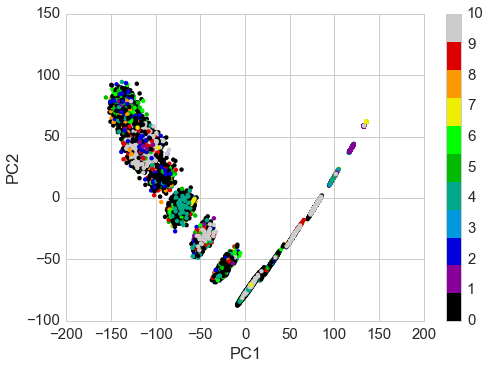

In [15]:
# use PCA analysis to see if we can separate the peptides
pca = PCA(n_components=2)
pca.fit(X)
reduced = pca.transform(X)

# plot results
plt.scatter(reduced[0::, 0], reduced[0::, 1], c=y, edgecolor="none",
            cmap=plt.cm.get_cmap("nipy_spectral",11))
plt.colorbar()
plt.xlabel("PC1")
plt.ylabel("PC2")

####We can see that the peptides are not well seperated just by peptide sequences.

In [16]:
# divide dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# train and predict using Random Forests
model = RandomForestClassifier(n_estimators=500)
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

In [17]:
# check the F1 score of the prediction
f1 = metrics.f1_score(y_test, y_predicted, average="micro")
print "F1 score: {0:.2f}%".format(f1*100)

F1 score: 61.93%


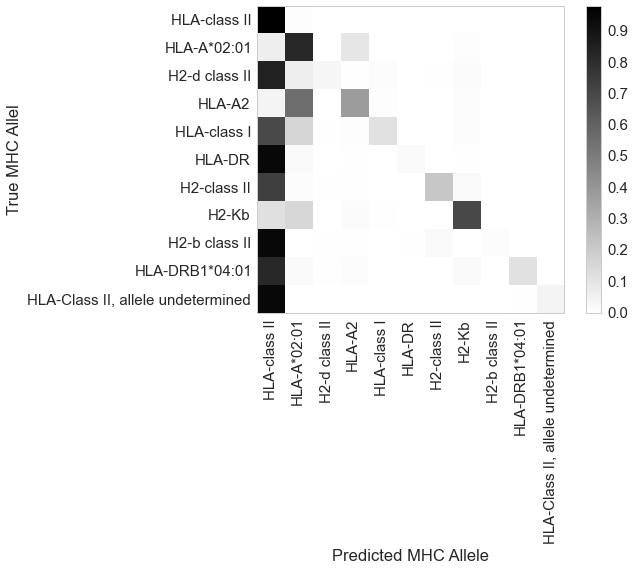

In [18]:
# visualize the results
result_matrix = metrics.confusion_matrix(y_test, y_predicted)
result_matrix = result_matrix.astype(np.float) / result_matrix.sum(axis=1, keepdims=True)

fig, ax = plt.subplots()
plt.imshow(result_matrix, interpolation="nearest", cmap=plt.cm.binary)
plt.grid(False)
plt.colorbar()
plt.xticks(np.arange(0, 11, 1), rotation="vertical")
plt.yticks(np.arange(0, 11, 1))
ax.set_yticklabels(allele_names["Allele"])
ax.set_xticklabels(allele_names["Allele"])
plt.xlabel("Predicted MHC Allele")
plt.ylabel("True MHC Allel")

##In this project, I have developed a simple model for MHC binding predictions based on peptide sequences. Due to the facts that most peptides in the dataset bind to HLA-class II and that  HLA-DR, HLA-DRB1*04:01, and undetermined HLA-Calss II molecules are also HLA-class II molecules, the model tended to consider these molecues as HLA-class II. Nevetheless, the model did reasonably well in predicting MHC class I molecues including HLA-A*02:01 and H2-Kb. Finally, other factors such as the biochemical properties of each amino acid need to be considered to improve current model.